# Thomas Fire: Land Cover and Climate Projection

Author: Haylee Oyler

## About

This notebook explores land cover change after the 2017 Thomas Fire in Santa Barbara and Ventura Counties. 

## Data

### References

In [192]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
from shapely import box
from IPython.display import Image 
import scipy.stats as stats

# MPC 
import pystac_client
import planetary_computer
import odc.stac
from pystac.extensions.eo import EOExtension as eo


# Cal-Aapt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point


## Fire Perimeter Preparation

In [138]:
# Read fire perimeter of interest
ranch_fire = gpd.read_file(os.path.join('data', 'thomas_boundary.geojson'))

# Explore CRS
ranch_fire.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

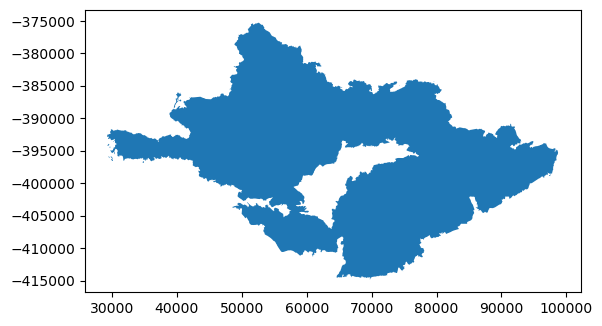

In [139]:
ranch_fire.plot()

## MPC Catalog Search

In [140]:
# Get bounding box for thomas fire 
ranch_fire_bbox = list(ranch_fire.to_crs('epsg:4326').total_bounds)

# Set time period of interest
time_of_interest = "2018-07-25/2018-09-01"

In [141]:
# Open MPC data catalog connection
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

# Search MPC catalog 
search = catalog.search(collections=['landsat-c2-l2'],
                        datetime=time_of_interest,
                        bbox=ranch_fire_bbox,
                        query={
                            "eo:cloud_cover": {"lt": 10},
                            # Landsat 8 and 9 were chosen to avoid landsat 7 data collection failure
                            "platform": {"in": ["landsat-8", "landsat-9"]}
                            }
                        )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 3 Items


In [142]:
# View different item options 
for item in items:
    cloud_cover = eo.ext(item).cloud_cover
    print(f"Item: {item.id} on {item.datetime.date()}, Cloud Cover: {cloud_cover}%")

# Select the item with the minimum cloud cover
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

# print(
#     f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
#     + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
# )

Item: LC08_L2SP_041036_20180831_02_T1 on 2018-08-31, Cloud Cover: 0.02%
Item: LC08_L2SP_041036_20180815_02_T1 on 2018-08-15, Cloud Cover: 2.51%
Item: LC08_L2SP_042036_20180806_02_T1 on 2018-08-06, Cloud Cover: 0.23%


In [143]:
# View the pre-rendered image to confirm we've got the right area
Image(url=selected_item.assets['rendered_preview'].href, width=600)

In [144]:
# View the available assets
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [145]:
# Select bands of interest for visualization
bands_of_interest = ["nir08", "red", "green", "blue", "swir16", "swir22"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=ranch_fire_bbox
).isel(time=0)
data

<xarray.Dataset> Size: 39MB
Dimensions:      (y: 1375, x: 2348)
Coordinates:
  * y            (y) float64 11kB 3.836e+06 3.836e+06 ... 3.795e+06 3.795e+06
  * x            (x) float64 19kB 2.531e+05 2.532e+05 ... 3.235e+05 3.236e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2018-08-31T18:27:53.169417
Data variables:
    nir08        (y, x) uint16 6MB 0 0 0 0 0 0 ... 17645 16415 16476 15736 15790
    red          (y, x) uint16 6MB 0 0 0 0 0 0 ... 14038 12674 12295 11092 11693
    green        (y, x) uint16 6MB 0 0 0 0 0 0 ... 12466 11672 11379 10446 10856
    blue         (y, x) uint16 6MB 0 0 0 0 0 0 ... 10878 10372 9968 9584 9775
    swir16       (y, x) uint16 6MB 0 0 0 0 0 0 ... 20363 19252 17800 15901 17608
    swir22       (y, x) uint16 6MB 0 0 0 0 0 0 ... 17838 17089 15705 13484 14704

Text(0.5, 1.0, 'True Color Image Mendocino Complex Fire, Mendocino County, CA')

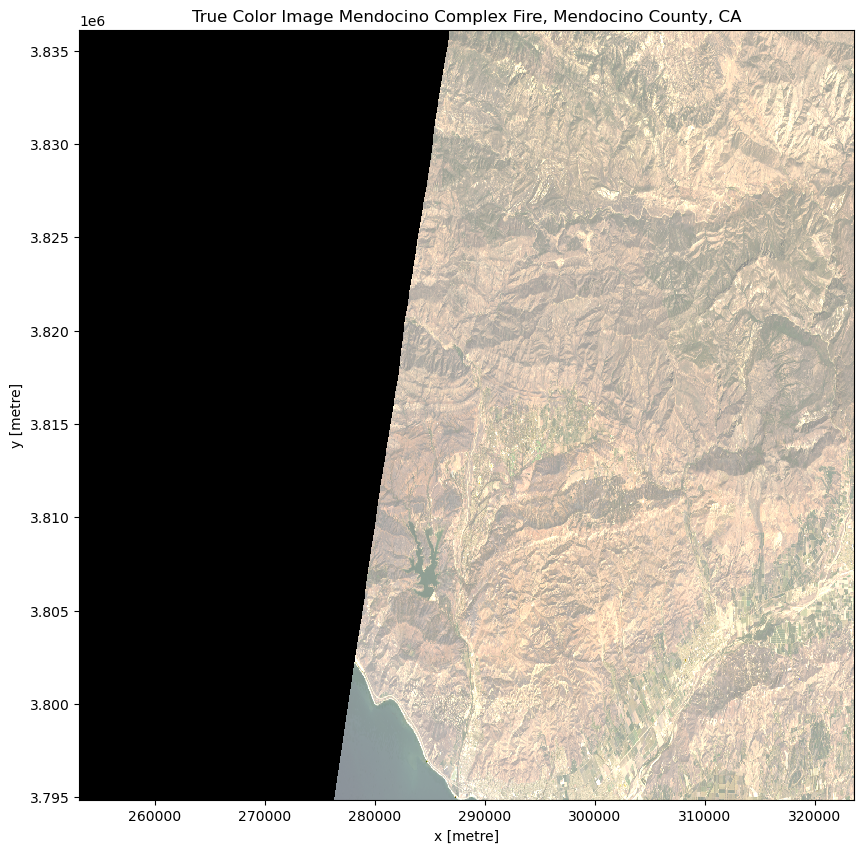

In [146]:
# Plot a true color image
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("True Color Image Mendocino Complex Fire, Mendocino County, CA")

NameError: name 'data' is not defined

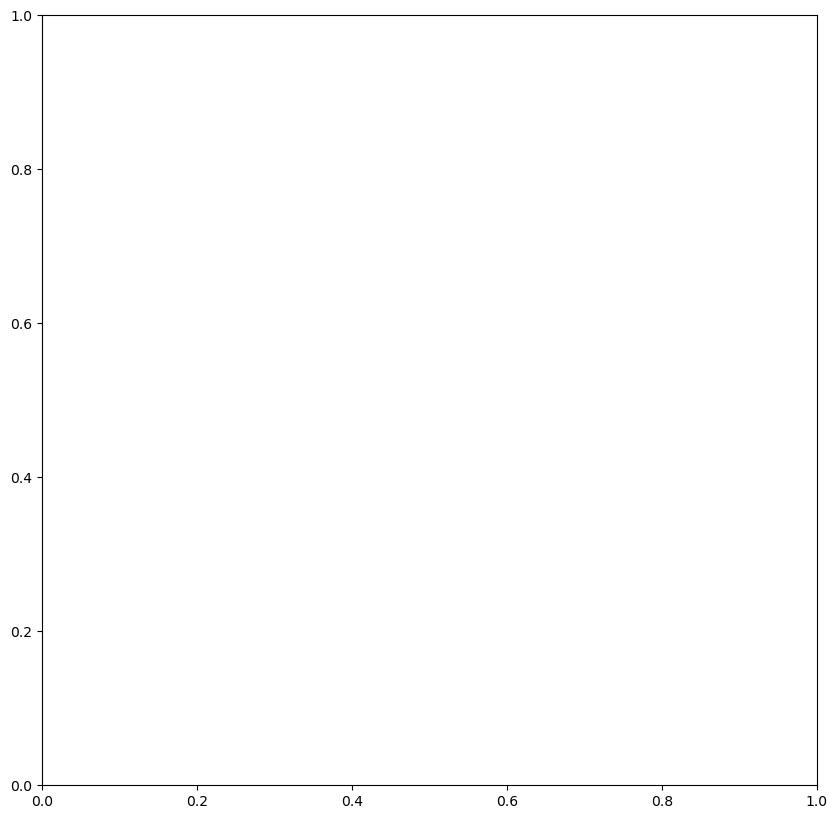

In [ ]:
# Generate a false color image to see the fire perimeter 
fig, ax = plt.subplots(figsize=(10, 10))

data[["swir22", "nir08", "red"]].to_array().plot.imshow(robust=True, ax=ax)

ax.set_title("False Color Image Mendocino Complex Fire, Mendocino County, CA")

Normalized Burn Index = NIR - SWIR / NIR + SWIR

In [13]:
# Change our time period of interest to before the fire
time_of_interest = "2018-01-01/2018-07-01"

# Search MPC catalog 
search = catalog.search(collections=['landsat-c2-l2'],
                        datetime=time_of_interest,
                        bbox=ranch_fire_bbox,
                        query={
                            "eo:cloud_cover": {"lt": 10},
                            # Landsat 8 and 9 were chosen to avoid landsat 7 data collection failure
                            "platform": {"in": ["landsat-8", "landsat-9"]}
                            }
                        )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 12 Items


In [14]:
# Select the item with the minimum cloud cover
pre_burn_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {pre_burn_item.id} from {pre_burn_item.datetime.date()}"
    + f" with {pre_burn_item.properties['eo:cloud_cover']}% cloud cover"
)

# Select bands of interest for visualization
bands_of_interest = ["nir08", "red", "green", "blue", "swir16", "swir22"]
pre_burn_data = odc.stac.stac_load(
    [pre_burn_item], bands=bands_of_interest, bbox=ranch_fire_bbox
).isel(time=0)


Choosing LC08_L2SP_045033_20180507_02_T1 from 2018-05-07 with 0.04% cloud cover


Text(0.5, 1.0, 'Change in Normalized Burn Ratio Post-Mendocino Complex Fire, Mendocino County, CA')

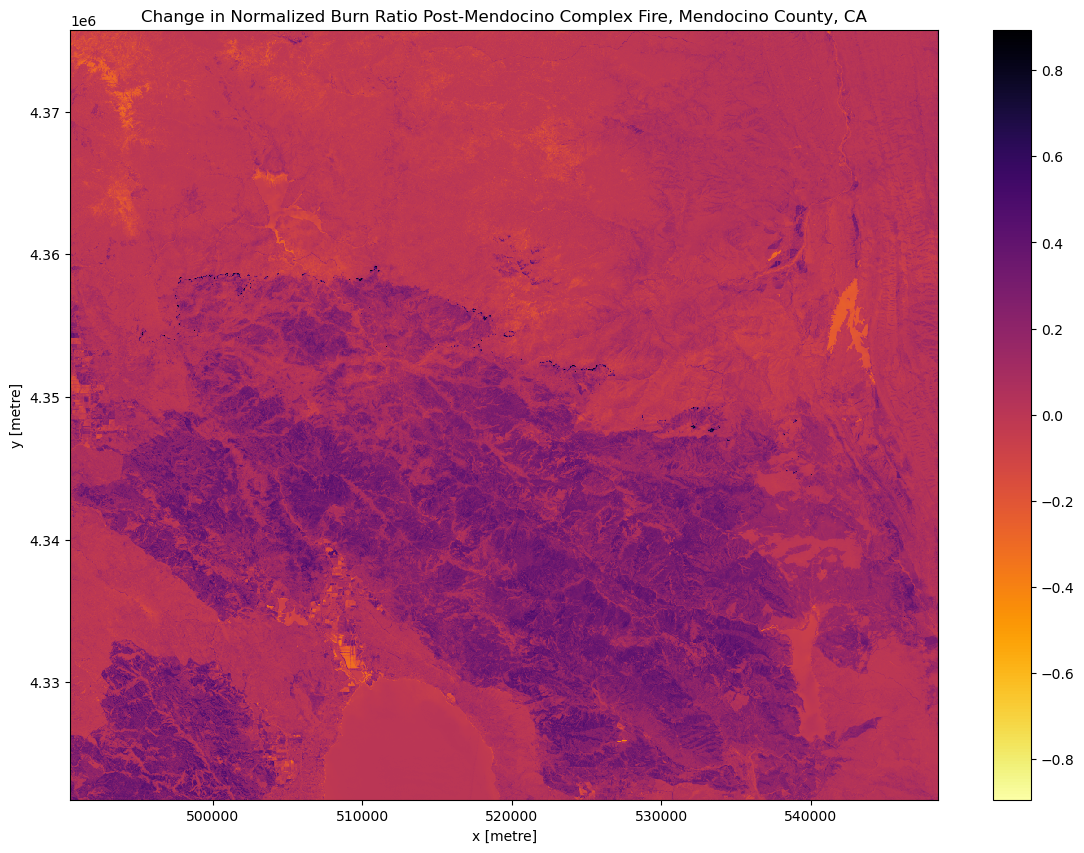

In [15]:
# Pre-burn NBR
pre_swir = pre_burn_data["swir22"].astype("float")
pre_nir = pre_burn_data["nir08"].astype("float")
pre_nbr = (pre_nir - pre_swir) / (pre_nir + pre_swir)

# Post-burn NBR
post_swir = data["swir22"].astype("float")
post_nir = data["nir08"].astype("float")
post_nbr = (post_nir - post_swir) / (post_nir + post_swir)

# Difference in NBR
# nbr_diff = post_nbr - pre_nbr
nbr_diff =  pre_nbr - post_nbr


fig, ax = plt.subplots(figsize=(14, 10))
nbr_diff.plot.imshow(ax=ax, cmap="inferno_r")
ax.set_title("Change in Normalized Burn Ratio Post-Mendocino Complex Fire, Mendocino County, CA")

We can see this raster is much larger than the extent of the thomas fire, but we are in the right location! 

Next, we'll import the csv with class labels from [DATA SOURCE]

In [9]:
labels = pd.read_csv(os.path.join('data', 'GAP_National_Terrestrial_Ecosystems.csv'))

labels.head()

class_label  code
0                                    0     0
1          South Florida Bayhead Swamp     1
2           South Florida Cypress Dome     2
3  South Florida Dwarf Cypress Savanna     3
4         South Florida Mangrove Swamp     4

## Explore Raster

In [87]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog 
search = catalog.search(collections=['gap'], 
                        bbox=ranch_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


In [88]:
# Select unique search item
item = items[0]  

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

In [89]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [90]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

Sizes of dimensions: {'y': 10000, 'x': 10000}


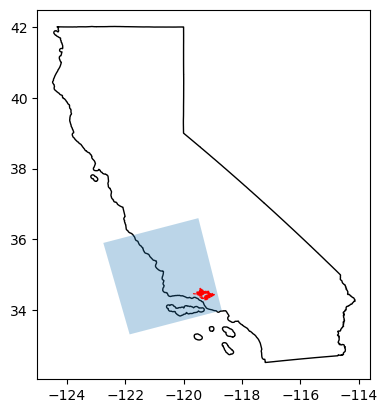

In [91]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                            crs = lulc.rio.crs)

ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))

# ------------------------------------------------------------------
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')

# Reproject lulc_bbox and fire perimeter to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)  
ranch_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

## Clip Raster to Geometry

/Users/hayleeoyler/miniforge3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


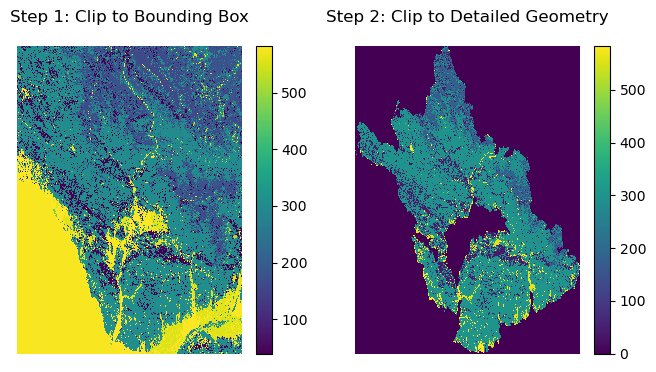

In [92]:
# Match CRS and verify update
ranch_fire_match = ranch_fire.to_crs(lulc.rio.crs)
assert ranch_fire_match.crs == lulc.rio.crs

# Clip large raster to detailed geometry in two steps
lulc_step1 = lulc.rio.clip_box(*ranch_fire_match.total_bounds)
lulc_step2 = lulc_step1.rio.clip(ranch_fire_match.geometry)  # Produces RuntimeWarning

# ------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first clipped raster
lulc_step1.plot(ax=ax[0])
ax[0].set_title("Step 1: Clip to Bounding Box")
ax[0].axis("off")

# Plot the second clipped raster
lulc_step2.plot(ax=ax[1])
ax[1].set_title("Step 2: Clip to Detailed Geometry")
ax[1].axis("off")

plt.show()

Notice a RunTimeWarning appeared when we clipped the raster. This occurs because the `rio.clip()` function tries to fill values outside the fire perimeter with np.nan. However, as we previously saw, our raster’s data type is uint16 (16 bits unsigned integer). The cast issue appears since np.nan is a float (decimal number) and it cannot be casted as a uint16. To make sure the clipping operator fills in any pixels with the adequate no-data value, let’s manually set it:

In [93]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  None
Updated no-data value:  0


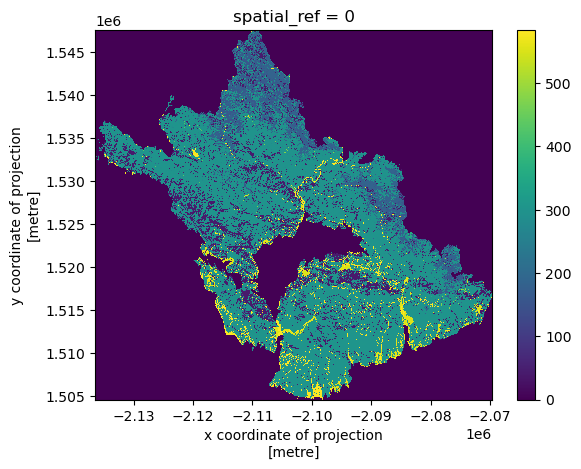

In [94]:
lulc_clip = (lulc.rio.clip_box(*ranch_fire_match.total_bounds)
                .rio.clip(ranch_fire_match.geometry)
                )

# Examine results
lulc_clip.plot()                                  

In [107]:
# Get the number of pixels per class
values, counts = np.unique(lulc_clip, return_counts = True)

# Store values and counts in a dataframe
pix_counts = pd.DataFrame({
    'code' : values,
    'pixel_count' : counts,
})

pix_counts.head()

code  pixel_count
0     0      1927854
1    39         6857
2    40          361
3    41       133701
4    42         3635

Use the labels data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

In [111]:
# Import the class labels dataset
labels = pd.read_csv(os.path.join('data',
                    'GAP_National_Terrestrial_Ecosystems.csv')
                    )
labels.head()

class_label  code
0                                    0     0
1          South Florida Bayhead Swamp     1
2           South Florida Cypress Dome     2
3  South Florida Dwarf Cypress Savanna     3
4         South Florida Mangrove Swamp     4

In [108]:
# Join the pixel count and labels dfs
pix_label = pd.merge(pix_counts, labels, how="left", on='code')
pix_label.head()

code  pixel_count                                        class_label
0     0      1927854                                                  0
1    39         6857        California Central Valley Mixed Oak Savanna
2    40          361  California Coastal Closed-Cone Conifer Forest ...
3    41       133701   California Coastal Live Oak Woodland and Savanna
4    42         3635  California Lower Montane Blue Oak-Foothill Pin...

In [103]:
lulc_clip.rio.resolution()

(30.0, -30.0)

In [160]:
# Filtering out the 'no data' class
valid_classes = pix_label[pix_label['code'] != 0].copy()
# valid_classes = pix_label.loc[pix_label['code'] != 0]

# Find the total pixels to calculate land cover percentages
total_pixels = valid_classes['pixel_count'].sum()

valid_classes['percentage'] = (valid_classes['pixel_count'] / total_pixels) * 100

valid_classes = valid_classes[['class_label', 'percentage']].sort_values(by='percentage', ascending=False).set_index('class_label')
valid_classes.head(10)

percentage
class_label                                                   
Southern California Coastal Scrub                    35.869680
Southern California Dry-Mesic Chaparral              14.518056
California Coastal Live Oak Woodland and Savanna     10.551749
California Central Valley and Southern Coastal ...    6.984464
Great Basin Pinyon-Juniper Woodland                   5.991881
Mediterranean California Mesic Serpentine Woodl...    5.500680
California Mesic Chaparral                            5.056278
Mediterranean California Dry-Mesic Mixed Conife...    4.751250
Developed, Open Space                                 3.208986
Central and Southern California Mixed Evergreen...    1.826852

/var/folders/ck/21jw_cxj7j984t_wcgbyrv200000gn/T/ipykernel_72854/2364569805.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[


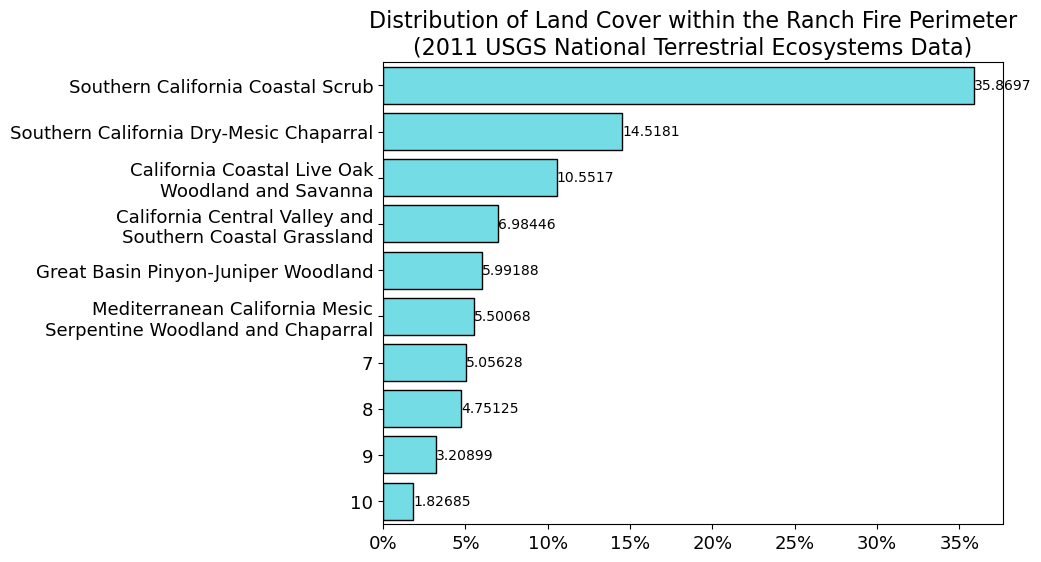

In [208]:
# Plot accuracy scores across models
plt.figure(figsize=(8,6))

ax = sns.barplot(data = valid_classes['percentage'].head(10), 
                legend=True, orient='h',
                color='#60ECF7', edgecolor='black')

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container)


ax.set_title('Distribution of Land Cover within the Ranch Fire Perimeter\n(2011 USGS National Terrestrial Ecosystems Data)', fontsize = 16)
plt.ylabel('')
plt.xlabel('')

ax.tick_params(labelsize=13)

# ax.set_yticks('values')
ax.set_yticklabels(labels=[
    'Southern California Coastal Scrub', 'Southern California Dry-Mesic Chaparral',
    'California Coastal Live Oak\nWoodland and Savanna', 'California Central Valley and\nSouthern Coastal Grassland',
    'Great Basin Pinyon-Juniper Woodland', 'Mediterranean California Mesic\nSerpentine Woodland and Chaparral',
    '7', '8', '9', '10'])


# Format x-axis tick labels as percentages
formatter = mtick.PercentFormatter(xmax=100, decimals=0) 
ax.xaxis.set_major_formatter(formatter)

plt.show()

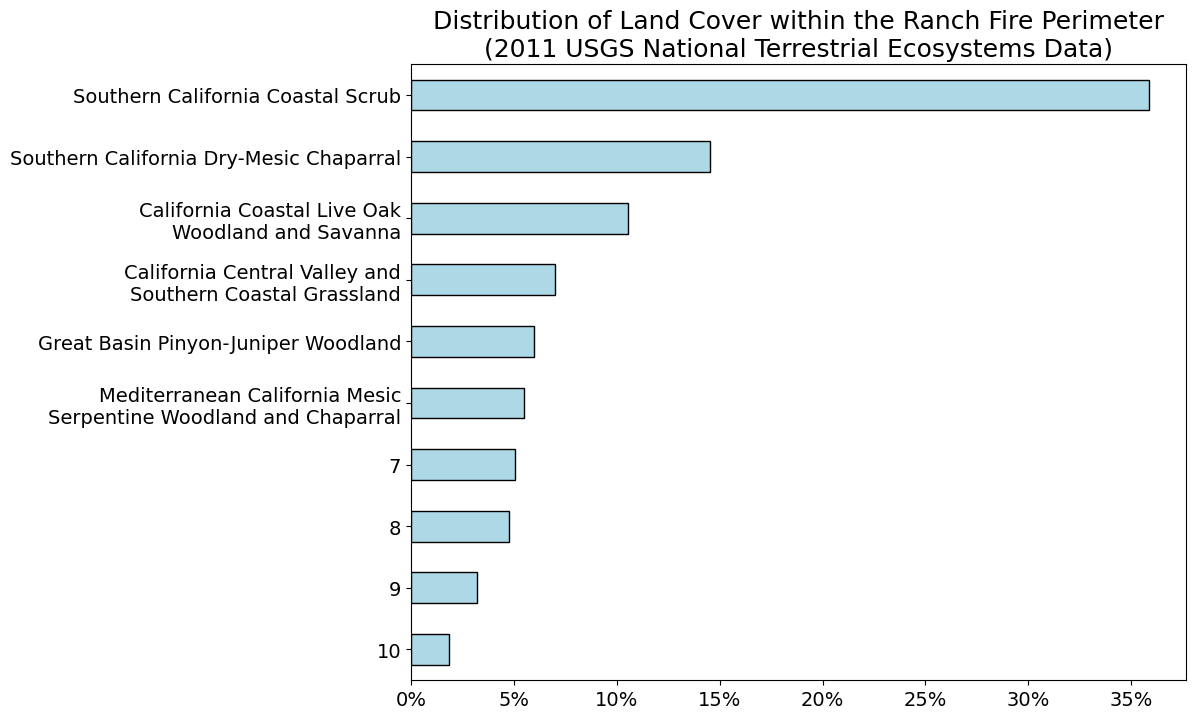

In [190]:
fig, ax = plt.subplots(figsize=(10,8))

valid_classes['percentage'].head(10).plot(kind='barh', color='lightblue', edgecolor='black')

ax.set_title('Distribution of Land Cover within the Ranch Fire Perimeter\n(2011 USGS National Terrestrial Ecosystems Data)', fontsize = 18)


plt.ylabel('')
ax.tick_params(labelsize=14)
ax.set_yticklabels(labels=[
    'Southern California Coastal Scrub', 'Southern California Dry-Mesic Chaparral',
    'California Coastal Live Oak\nWoodland and Savanna', 'California Central Valley and\nSouthern Coastal Grassland',
    'Great Basin Pinyon-Juniper Woodland', 'Mediterranean California Mesic\nSerpentine Woodland and Chaparral',
    '7', '8', '9', '10'])

# Format x-axis tick labels as percentages
formatter = mtick.PercentFormatter(xmax=100, decimals=0) # xmax=1.0 assumes your x-values are already in decimal form (e.g., 0.1 for 10%)
ax.xaxis.set_major_formatter(formatter)

# ax.set_xticklabels(fontsize=14)
ax.invert_yaxis()
plt.show()

In [ ]:
lulc_clip

<xarray.DataArray (y: 1874, x: 1782)> Size: 7MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * x            (x) float64 14kB -2.287e+06 -2.287e+06 ... -2.234e+06
  * y            (y) float64 15kB 2.155e+06 2.155e+06 ... 2.099e+06 2.098e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

In [72]:
lulc_clip.TIFFTAG_RESOLUTIONUNIT


'2 (pixels/inch)'

In [74]:
# Get the raster resolution (pixel size)
pixel_width = abs(lulc_clip.rio.resolution()[0])  # Width in map units
pixel_height = abs(lulc_clip.rio.resolution()[1])  # Height in map units
pixel_area = pixel_width * pixel_height  # Area per pixel in map units²

print(f"Pixel resolution: {pixel_width} x {pixel_height}")
print(f"Pixel area: {pixel_area} map units²")
print(f"CRS: {lulc_clip.rio.crs}")

# Check what the map units are (likely meters for this projection)
print(f"CRS info: {lulc_clip.rio.crs.to_string()}")

Pixel resolution: 30.0 x 30.0
Pixel area: 900.0 map units²
CRS: EPSG:5070
CRS info: EPSG:5070


In [77]:
# Convert pixel area from m² to km² (assuming map units are meters)
pixel_area_km2 = pixel_area / 1_000_000  # Convert m² to km²

# Find developed land classes in your data
# Look at your pix_label dataframe to identify developed classes
print("Available land cover classes:")
print(pix_label[['class', 'class_label']].head(10))

# Filter for developed classes (you'll need to identify the correct class codes)
# Common developed class codes might be in ranges like 9100-9999
developed_classes = pix_label[pix_label['class_label'].str.contains('Developed|Urban', case=False, na=False)]
print("\nDeveloped classes found:")
print(developed_classes)

# Calculate total developed area
if not developed_classes.empty:
    total_developed_pixels = developed_classes['pixel_count'].sum()
    developed_area_km2 = total_developed_pixels * pixel_area_km2
    
    print(f"\nDeveloped area calculation:")
    print(f"Total developed pixels: {total_developed_pixels}")
    print(f"Pixel area: {pixel_area_km2:.6f} km²")
    print(f"Total developed area: {developed_area_km2:.2f} km²")
else:
    print("No developed classes found. Check class names manually.")

Available land cover classes:
   class                                        class_label
0      0                                                  0
1     39        California Central Valley Mixed Oak Savanna
2     41   California Coastal Live Oak Woodland and Savanna
3     42  California Lower Montane Blue Oak-Foothill Pin...
4     44  Mediterranean California Lower Montane Black O...
5     55    Mediterranean California Mixed Evergreen Forest
6     56        Mediterranean California Mixed Oak Woodland
7    159  California Montane Jeffrey Pine-(Ponderosa Pin...
8    162  Mediterranean California Dry-Mesic Mixed Conif...
9    163  Mediterranean California Mesic Mixed Conifer F...

Developed classes found:
    class  pixel_count                  class_label
33    581        44826        Developed, Open Space
34    582          623     Developed, Low Intensity
35    583           55  Developed, Medium Intensity
36    584           12    Developed, High Intensity

Developed area calculat

## Cal-Adapt Climate Data

In [6]:
# Open connection to the Cal-Adapt data catalog
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

# View the data frame
cat_df = catalog.df
cat_df

activity_id institution_id   source_id experiment_id member_id table_id  \
0          LOCA2           UCSD  ACCESS-CM2    historical  r1i1p1f1      day   
1          LOCA2           UCSD  ACCESS-CM2    historical  r1i1p1f1      day   
2          LOCA2           UCSD  ACCESS-CM2    historical  r1i1p1f1      day   
3          LOCA2           UCSD  ACCESS-CM2    historical  r1i1p1f1      day   
4          LOCA2           UCSD  ACCESS-CM2    historical  r1i1p1f1      day   
...          ...            ...         ...           ...       ...      ...   
8171         WRF           UCSD   FGOALS-g3        ssp370  r1i1p1f1      day   
8172         WRF           UCSD   FGOALS-g3        ssp370  r1i1p1f1      day   
8173         WRF           UCSD   FGOALS-g3        ssp370  r1i1p1f1      day   
8174         WRF           UCSD   FGOALS-g3        ssp370  r1i1p1f1      day   
8175         WRF           UCSD   FGOALS-g3        ssp370  r1i1p1f1      day   

     variable_id grid_label                                               path  
0        hursmax        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
1        hursmin        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
2           huss        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
3             pr        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
4           rsds        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
...          ...        ...                                                ...  
8171       t2max        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
8172       t2min        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
8173         u10        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
8174         v10        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
8175  wspd10mean        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  

[8176 rows x 9 columns]

In [7]:
# Print out all unique grid labels
print(catalog.df.grid_label.unique())

# Print out all unique variable_id values
print(catalog.df.variable_id.unique())

# Print out all unique table_id values
print(catalog.df.table_id.unique())

# Display all the variables available at different time resolutions
# daily
# print(cat_df[cat_df["table_id"] == "day"].variable_id.unique())

# # monthly
print(cat_df[cat_df["table_id"] == "mon"].variable_id.unique())


<ArrowExtensionArray>
['d03', 'd01', 'd02']
Length: 3, dtype: large_string[pyarrow]
<ArrowExtensionArray>
[      'hursmax',       'hursmin',          'huss',            'pr',
          'rsds',        'tasmax',        'tasmin',           'uas',
           'vas',        'wspeed',          'ffwi',        'lwdnbc',
         'lwdnb',        'lwupbc',         'lwupb',          'prec',
          'psfc',            'q2',         'rainc',        'rainnc',
         'runsb',         'runsf',          'snow',        'snownc',
        'swddif',        'swdnbc',         'swdnb',        'swupbc',
         'swupb',            't2',           'tsk',           'u10',
           'v10',    'etrans_sfc',      'evap_sfc',        'gh_sfc',
           'iwp',        'lh_sfc',        'lw_dwn',           'lwp',
        'lw_sfc',        'prec_c',      'prec_max',     'prec_snow',
            'rh',    'sfc_runoff',        'sh_sfc', 'subsfc_runoff',
        'sw_dwn',        'sw_sfc',         't2max',         't2min

### Model Selection: LOCA2

Cal-Adapt's catalog has available downscaling techniques: LOCA2 and WRF.

**LOCA2**: Localized Constructed Analogs that use a statistical approach to downscaling large climate models. This uses high resolutions local spatial data to "fill in" the gaps of the lower resolution global climate model. 

**WRF**: Weather Research and Forecasting model that uses a dynamic approach to downscaling.

In [8]:
# activity_id: which downscaling technique do you want?
activity_id = ["LOCA2"]

# experiment_id: which historical/future scenario do you want?
experiment_ids = ["historical", "ssp370"]

source_id = ['CESM2-LENS']

# table_id: which time resolution do you want?
table_id = ["day"]

# variable_id: which variable do you want?
variable_id = ["tasmax"]

In [9]:
# Search through catalog, store results
loca = catalog.search(activity_id=activity_id, experiment_id=experiment_ids, source_id=source_id,
                    table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
loca_df = loca.df
loca_df

activity_id institution_id   source_id experiment_id  member_id table_id  \
0        LOCA2           UCSD  CESM2-LENS    historical  r10i1p1f1      day   
1        LOCA2           UCSD  CESM2-LENS    historical   r1i1p1f1      day   
2        LOCA2           UCSD  CESM2-LENS    historical   r2i1p1f1      day   
3        LOCA2           UCSD  CESM2-LENS    historical   r3i1p1f1      day   
4        LOCA2           UCSD  CESM2-LENS    historical   r4i1p1f1      day   
5        LOCA2           UCSD  CESM2-LENS    historical   r5i1p1f1      day   
6        LOCA2           UCSD  CESM2-LENS    historical   r6i1p1f1      day   
7        LOCA2           UCSD  CESM2-LENS    historical   r7i1p1f1      day   
8        LOCA2           UCSD  CESM2-LENS    historical   r8i1p1f1      day   
9        LOCA2           UCSD  CESM2-LENS    historical   r9i1p1f1      day   
10       LOCA2           UCSD  CESM2-LENS        ssp370  r10i1p1f1      day   
11       LOCA2           UCSD  CESM2-LENS        ssp370   r1i1p1f1      day   
12       LOCA2           UCSD  CESM2-LENS        ssp370   r2i1p1f1      day   
13       LOCA2           UCSD  CESM2-LENS        ssp370   r3i1p1f1      day   
14       LOCA2           UCSD  CESM2-LENS        ssp370   r4i1p1f1      day   
15       LOCA2           UCSD  CESM2-LENS        ssp370   r5i1p1f1      day   
16       LOCA2           UCSD  CESM2-LENS        ssp370   r6i1p1f1      day   
17       LOCA2           UCSD  CESM2-LENS        ssp370   r7i1p1f1      day   
18       LOCA2           UCSD  CESM2-LENS        ssp370   r8i1p1f1      day   
19       LOCA2           UCSD  CESM2-LENS        ssp370   r9i1p1f1      day   

   variable_id grid_label                                               path  
0       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
1       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
2       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
3       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
4       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
5       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
6       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
7       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
8       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
9       tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/historical/r...  
10      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r10i1...  
11      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r1i1p...  
12      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r2i1p...  
13      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r3i1p...  
14      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r4i1p...  
15      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r5i1p...  
16      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r6i1p...  
17      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r7i1p...  
18      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r8i1p...  
19      tasmax        d03  s3://cadcat/loca2/ucsd/cesm2-lens/ssp370/r9i1p...

In [10]:
# Read in first entry, display metadata
loca_data = xr.open_zarr(loca_df['path'].iloc[0], storage_options={'anon': True})

In [11]:
# Display the contents of the "prec" variable
loca_data.tasmax

<xarray.DataArray 'tasmax' (time: 23741, lat: 495, lon: 559)> Size: 26GB
dask.array<open_dataset-tasmax, shape=(23741, 495, 559), dtype=float32, chunksize=(1697, 132, 149), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB -128.4 -128.4 -128.4 ... -111.0 -111.0 -111.0
  * time     (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31T1...
Attributes:
    long_name:  tasmax
    units:      K

In [12]:
# CESM2 historical
loca_hist = loca_df[loca_df["experiment_id"] == "historical"]

# CESM2 SSP3-7.0
loca_ssp = loca_df[loca_df["experiment_id"] == "ssp370"]

In [13]:
# Make a list of the unique ensemble members
# historical
mems_hist = loca_hist.member_id.unique()
# SSP
mems_ssp = loca_ssp.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

print(common_mems)

['r7i1p1f1', 'r6i1p1f1', 'r3i1p1f1', 'r1i1p1f1', 'r8i1p1f1', 'r4i1p1f1', 'r2i1p1f1', 'r9i1p1f1', 'r10i1p1f1', 'r5i1p1f1']


In [21]:
# Define an empty list
cesm2_loca_data = []

# Get fire perimeter bounds in lat/lon (you already have this)
ranch_fire_bounds_4326 = ranch_fire.to_crs('epsg:4326').total_bounds
min_lon, min_lat, max_lon, max_lat = ranch_fire_bounds_4326

# Loop over all common ensemble members
for mem in range(len(common_mems)):
    print(common_mems[mem])

    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = loca_hist['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = loca_hist['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = loca_ssp['member_id'] == common_mems[mem]
    ssp_loc = loca_ssp['member_id'][ssp_mask].index[0]
    
    # Store HISTORICAL data as xarray and clip to region of interest
    hist_data = xr.open_zarr(loca_hist['path'][hist_loc], storage_options={'anon': True})
    hist_data = hist_data.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
    
    # Store SSP3-7.0 data as xarray and clip to region of interest
    ssp_data = xr.open_zarr(loca_ssp['path'][ssp_loc], storage_options={'anon': True})
    ssp_data = ssp_data.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
    
    # Concatenate historical, SSP information
    temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
    # Add to list
    cesm2_loca_data.append(temp_data)

# Concatenate the list into a single xarray object
cesm2_loca_data = xr.concat(cesm2_loca_data, dim="member")

# Store the actual member information as values of the new dimension
cesm2_loca_data = cesm2_loca_data.assign_coords(member=("member", common_mems))

r7i1p1f1
r6i1p1f1
r3i1p1f1
r1i1p1f1
r8i1p1f1
r4i1p1f1
r2i1p1f1
r9i1p1f1
r10i1p1f1
r5i1p1f1


In [19]:
# Define an empty list
cesm2_loca_data = []

# Loop over all common ensemble members
for mem in range(len(common_mems)):
    print(common_mems[mem])

    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = loca_hist['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = loca_hist['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = loca_ssp['member_id'] == common_mems[mem]
    ssp_loc = loca_ssp['member_id'][ssp_mask].index[0]
    
    # Store HISTORICAL data as xarray
    hist_data = xr.open_zarr(loca_hist['path'][hist_loc], storage_options={'anon': True})
    
    # Store SSP3-7.0 data as xarray
    ssp_data = xr.open_zarr(loca_ssp['path'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate historical, SSP information
    temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
    # Add to list
    cesm2_loca_data.append(temp_data)

# Concatenate the list into a single xarray object
cesm2_loca_data = xr.concat(cesm2_loca_data, dim="member")

# Store the actual member information as values of the new dimension
cesm2_loca_data = cesm2_loca_data.assign_coords(member=("member", common_mems))

r7i1p1f1
r6i1p1f1
r3i1p1f1
r1i1p1f1
r8i1p1f1
r4i1p1f1
r2i1p1f1
r9i1p1f1
r10i1p1f1
r5i1p1f1


In [ ]:
# Print xarray object
print(cesm2_loca_data)
# Size dropped significantly, from 610 GB to 777 MB

<xarray.Dataset> Size: 777MB
Dimensions:  (member: 10, time: 55152, lat: 16, lon: 22)
Coordinates:
  * lat      (lat) float32 64B 39.05 39.08 39.11 39.14 ... 39.45 39.48 39.52
  * lon      (lon) float32 88B -123.1 -123.1 -123.0 ... -122.5 -122.5 -122.5
  * time     (time) datetime64[ns] 441kB 1950-01-01T12:00:00 ... 2100-12-31T1...
  * member   (member) <U9 360B 'r7i1p1f1' 'r6i1p1f1' ... 'r10i1p1f1' 'r5i1p1f1'
Data variables:
    tasmax   (member, time, lat, lon) float32 777MB dask.array<chunksize=(1, 1697, 16, 22), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                         CF-1.0
    ID_loca_routines_module:             $Id: loca_routines_module.F90,v 1.13...
    NCO:                                 4.6.7
    SIOCRD_netCDF_Version:               1.0
    SOURCE_loca_routines_module:         $Source: /home6/dwpierc2/src/mine/lo...
    bias_correction:                     downscaling via PresRat, Pierce et a...
    ...                                  ...
    opts_var_

In [23]:
# Get data for an earlier period
cesm2_locadata_early = cesm2_loca_data.sel(time=slice("1981-01-01", "2010-12-31"))
# cesm2_wrfdata_early = cesm2_wrf_data.sel(time=slice("1981-01-01", "2010-12-31"))

# Get data for a later period
cesm2_locadata_late = cesm2_loca_data.sel(time=slice("2071-01-01", "2100-12-31"))
# cesm2_wrfdata_late = cesm2_wrf_data.sel(time=slice("2071-01-01", "2100-12-31"))

# Calculate the differences
cesm2_loca_diff = cesm2_locadata_late.mean(dim="time") - cesm2_locadata_early.mean(dim="time")
# cesm2_wrf_diff = cesm2_wrfdata_late.mean(dim="time") - cesm2_wrfdata_early.mean(dim="time")

In [24]:
# Calculate the ensemble means
cesm2_loca_diff = cesm2_loca_diff.mean(dim="member")
# cesm2_wrf_diff = cesm2_wrf_diff.mean(dim="member")


In [25]:
# Extract LOCA2 values into a Numpy array
cesm2_loca_diff_pr = cesm2_loca_diff.tasmax.values

# Extract WRF values into a Numpy array
# cesm2_wrf_diff_pr = cesm2_wrf_diff.prec.values


In [27]:
# Display units for LOCA2, WRF data
print(cesm2_locadata_late.tasmax.units)

# print(cesm2_wrfdata_late.prec.units)

K


In [28]:
# Convert LOCA2 values to mm/day
cesm2_loca_diff_pr = cesm2_loca_diff_pr + 273.15

In [30]:
# Read in shapefile for CA counties
gdf = gpd.read_file('data/ca_counties/CA_Counties.shp')

# Reproject the shapefile to use the PlateCarree projection
gdf = gdf.to_crs(epsg=4326)

<GeoAxes: title={'center': 'CESM2 LOCA2 precip (late-century - historical)'}>

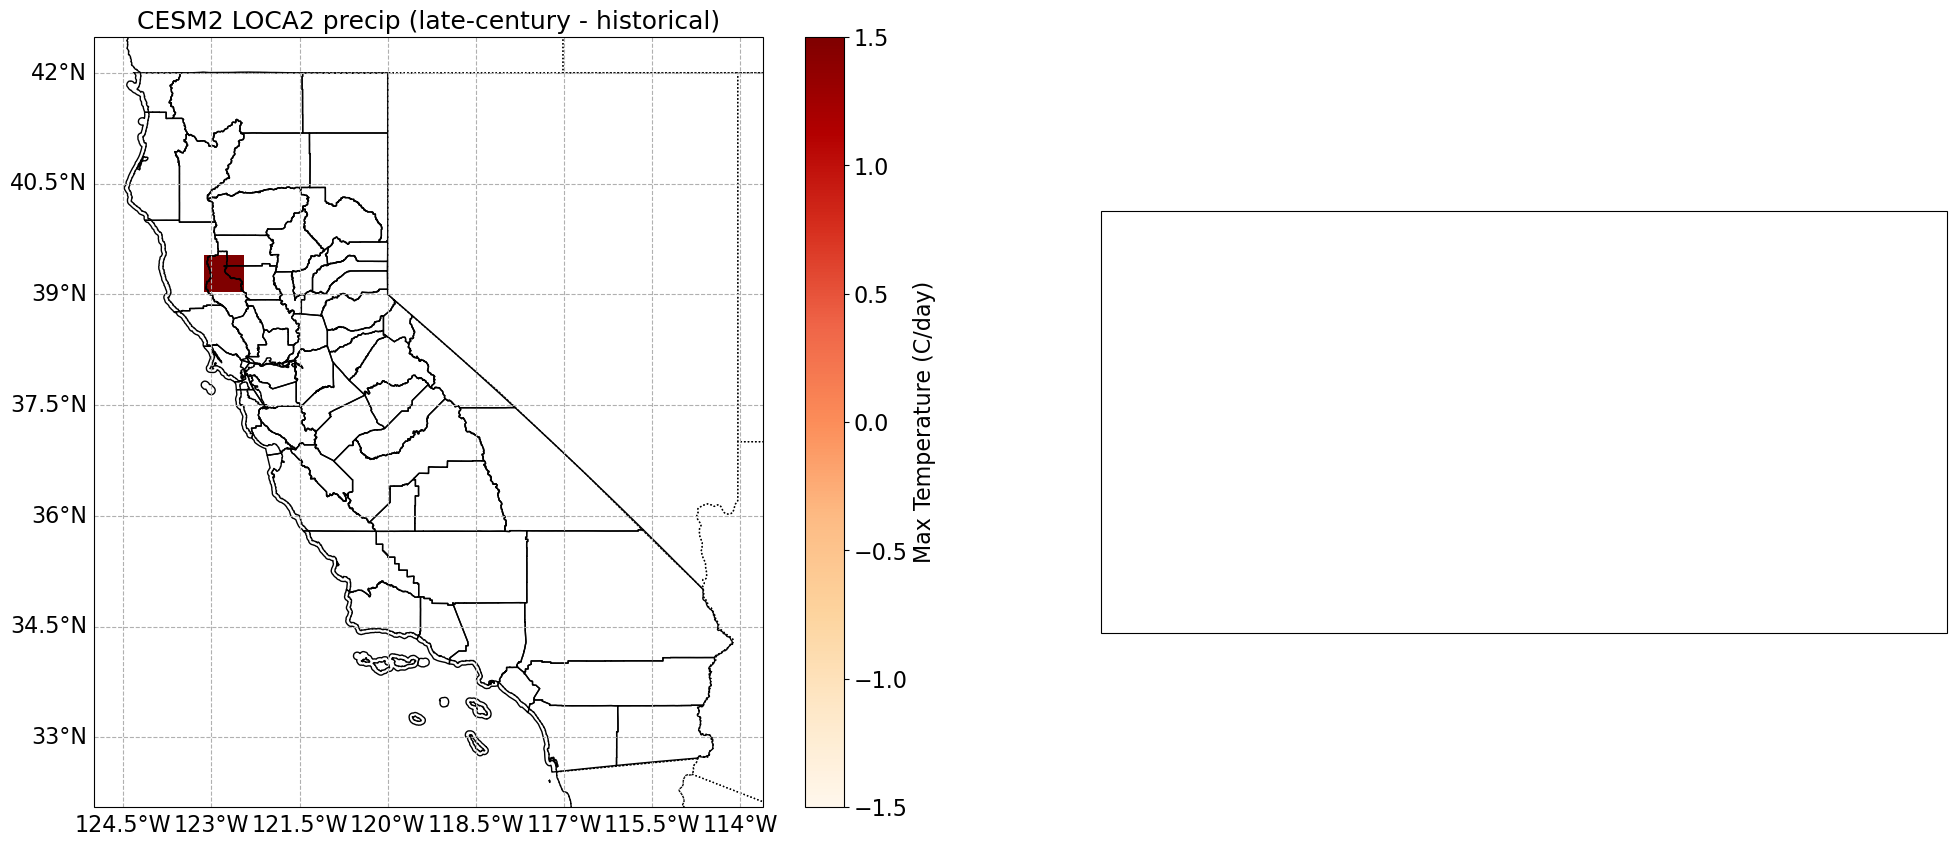

In [38]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: LOCA2
plot1 = axes[0].pcolormesh(cesm2_loca_diff.lon, cesm2_loca_diff.lat, cesm2_loca_diff_pr, 
                           transform=map, cmap="OrRd", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("Max Temperature (C/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("CESM2 LOCA2 precip (late-century - historical)", fontsize=18)

# Add county shape file
gdf.plot(ax=axes[0], facecolor='none', edgecolor='black', lw=1)

# Subplot 2: WRF
# plot2 = axes[1].pcolormesh(cesm2_wrf_diff.lon, cesm2_wrf_diff.lat, cesm2_wrf_diff_pr, 
#                            transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# # Add coastlines, state borders, and gridlines
# axes[1].add_feature(cfeature.COASTLINE)
# axes[1].add_feature(cfeature.STATES, linestyle=":")
# gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
# gl1.top_labels = False
# gl1.right_labels = False
# gl1.xlabel_style = {'size': 16}
# gl1.ylabel_style = {'size': 16}

# # Add colorbar
# cbar1 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
# cbar1.set_label("Precipitation (mm/day)", fontsize=16)
# cbar1.ax.tick_params(labelsize=16)

# axes[1].set_title("CESM2 WRF precip (late-century - historical)", fontsize=18)


In [ ]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: LOCA2
plot1 = axes[0].pcolormesh(cesm2_loca_diff.lon, cesm2_loca_diff.lat, cesm2_loca_diff_pr, 
                           transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# Add coastlines, borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("CESM2 LOCA2 precip (late-century - historical)", fontsize=18)

# Add county shape file
gdf.plot(ax=axes[0], facecolor='none', edgecolor='black', lw=1)

# Subplot 2: WRF
plot2 = axes[1].pcolormesh(cesm2_wrf_diff.lon, cesm2_wrf_diff.lat, cesm2_wrf_diff_pr, 
                            transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# Add coastlines, borders, and gridlines
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1].set_title("CESM2 WRF precip (late-century - historical)", fontsize=18)


